In [2]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from IPython.display import Image
import torch

# Diffusion on graphs

In the previous notebook we have looked at the diffusion and flux through continuous space. We now see how the same ideas can be extended to many other scenarious that include arbitrary structures such as networks and even social networks.

We start by reviewing the previous discretization of the diffusion equation.
We had a very simple structure of rectangular mesh. Every cell has only 4 neighbours that share a face in which flux can move from one cell to the other. This is demonstrated in the figure below


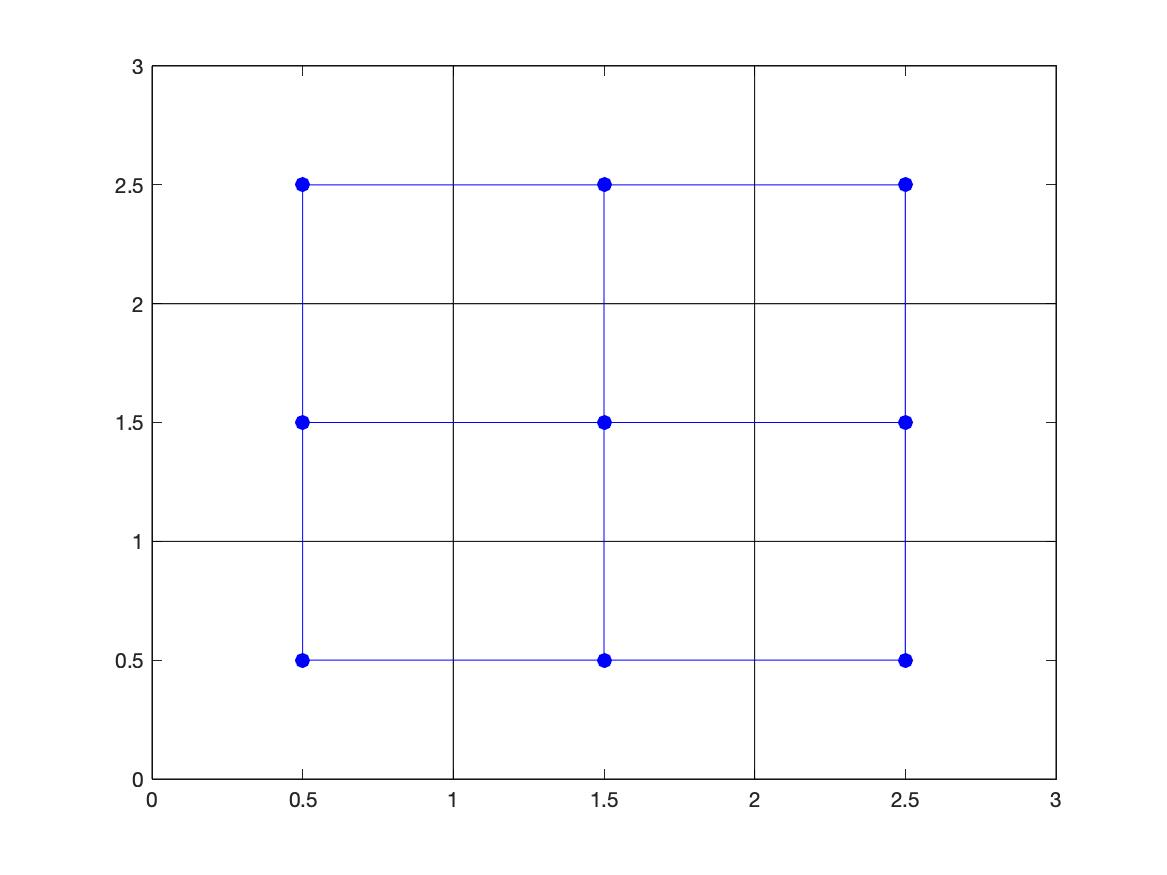

In [3]:
Image(filename='rectangularMesh.jpg')

There is a different way to obtain the same discrete version of the Laplacian we computed from the discretization of the continuous operator.
To do that, we view every cell as a node on a graph (the blue dots). Each  node (blue dot) is connected to some other nodes by an edge (blue line). The edges that connect the dots imply that there is a direct connection between the two. If there is no edge then this means that the flow has to go through other cells. 

This can be represented by matrices. First, assume we have $n$ nodes then we define an $n\times n$ adjencancy matrix $A$ as
$ A_{ij} = 1$, if node $i$ is linked to node $j$ and $0$ otherwise. 
For the graph above we have that
$$ A = \begin{pmatrix} 
1 & 1 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
1 & 1 & 1 & 0 & 1 & 0 & 0 & 0 & 0 \\
0 & 1 & 1 & 0 & 0 & 1 & 0 & 0 & 0 \\
1 & 0 & 0 & 1 & 1 & 0 & 1 & 0 & 0 \\
0 & 1 & 0 & 1 & 1 & 1 & 0 & 1 & 0 \\
0 & 0 & 1 & 0 & 1 & 1 & 0 & 0 & 1 \\
0 & 0 & 0 & 1 & 0 & 0 & 1 & 1 & 0 \\
0 & 0 & 0 & 0 & 1 & 0 & 1 & 1 & 1 \\
0 & 0 & 0 & 0 & 0 & 1 & 0 & 1 & 1 \\
\end{pmatrix} $$

The matrix is symmetric (if node $i$ is linked to $j$ then $j$ is linked to $i$. 
Let $d = \sum_i A_{ij} $. This number summarize the number of links that a node has.
Finally we define the graph Laplacian as
$$ L = {\rm diag}(d) - A $$

For the graph above represented by the grid we have that
$$ L = \begin{pmatrix} 
    2  &  -1  &   0 &   -1  &   0  &   0  &   0  &   0  &   0 \\
    -1  &   3 &   -1  &   0  &  -1  &   0  &   0  &   0  &   0 \\
     0  &  -1   &  2   &  0  &   0  &  -1  &   0 &    0  &   0 \\
    -1   &  0  &   0  &   3 &   -1   &  0 &   -1  &  0 &    0 \\
     0   & -1   &  0   & -1   &  4  &  -1  &   0  &  -1   &  0 \\
     0   &  0  &  -1  &   0 &   -1  &   3  &   0   &  0  &  -1 \\
     0   &  0   &  0  &  -1  &   0  &   0  &   2  &  -1   &  0 \\
     0   &  0   &  0  &   0  &  -1  &   0 &   -1  &   3  &  -1 \\
     0   &  0   &  0  &   0  &   0  &  -1 &    0   &  -1   &  2 
     \end{pmatrix} $$
     


The Laplacian matrix can be interpreted as a matrix representation of a particular case of the discrete Laplace operator. 
Suppose that
$\rho$ describes a density distribution across a graph, where 
$\rho_i$ is the density at vertex i. According to Darcy's law, the mass transferred between nodes 
i and j is proportional to difference in densities
$\rho_{i}-\rho_{j}$, with proportion $\kappa$, if nodes i and j are connected (if they are not connected, no mass is transferred). 

We can therefore write
$$ {\frac {d \rho_i}{dt}} = \kappa\sum_{j} A_{ij}(\rho_i - \rho_j) = \sum_{j} A_{ij}\rho_i - A_{ij}\rho_j $$
or by noting that $\sum A_{ij}\rho_j$ is nothing but the diagonal of $A$ wem obtain the vector equation
$$ {\frac {d \rho}{dt}} = \kappa({A - \rm diag}(d)) \rho = -\kappa L \rho $$

This is the heat equation represented as in a matrix form.



# The heat equation on arbitrary graphs

The nice thing about a graph is that we can represent more complex links. Consider now Canada and its provinces.
Each province can be thought of as a node. Nodes are linked if there is a direct connection between them (land or air).
So unlike the previous graph where only adjancent cells were linked, here cells like BC and Ontario are linked because there
is trafic between them.

First, let us define the nodes of Canada as
[AB, BC, MB, NB, NL, NT, NS, NU, ON, PE, QC, SK, YT]

We now define the adjancancy matrix is two nodes are linked by large amount of air/land trafic or not.

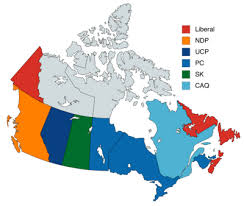

In [4]:
from IPython.display import Image
Image(filename='CanadaMap.jpg')

# Canada's adjencency matrix
Define the adjacency and graph Laplacian of the Canadian provices. We put a 1 if the provinces share a border or there is a significant trafic between them and zero otherwise.

We mark the provinces as
$P = \{'AB', 'BC', 'MB', 'NB', 'NL', 'NT', 'NS', 'NU', 'ON', 'PE', 'QC', 'SK', 'YT' \}$
and the adjecency matrix is


In [7]:
A = torch.tensor([[1,     1,     1,     0,     0,     0,     0,     0,     1,     0,     1,     1,     1],
     [1,     1,     1,     0,     0,     1,     0,     0,     1,     0,     1,     1,     0],
     [1,     1,     1,     0,     0,     1,     0,     1,     1,     0,     1,     1,     0],
     [0,     0,     0,     1,     1,     0,     0,     0,     1,     1,     1,     0,     0],
     [0,     0,     0,     1,     1,     0,     1,     0,     1,     1,     1,     0,     0],
     [0,     1,     1,     0,     0,     1,     0,     1,     1,     0,     1,     1,     1],
     [0,     0,     0,     0,     1,     0,     1,     0,     1,     1,     1,     0,     0],
     [0,     0,     1,     0,     0,     1,     0,     1,     1,     0,     1,     1,     1],
     [1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1],
     [0,     0,     0,     1,     1,     0,     1,     0,     1,     1,     1,     0,     0],
     [1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1],
     [1,     1,     1,     0,     0,     1,     0,     1,     1,     0,     1,     1,     0],
     [1,     0,     0,     0,     0,     1,     0,     1,     1,     0,     1,     0,     1]]);


# Propagation of desease on a graph

Suppose that there are $S=[S_1, ...,S_{13}]$ susceptible individuals that are located in different provinces. We 
ignore for a moment all interactions and growth. Then, the susceptible will propagate on the graph based on
the diffusion equation
$$ \dot{S} = -\kappa_S L S $$
where $\kappa_S$ is a diffusion constant.

Similarly, the propagation of infected, $I = [I_1,...,I_{13}]$, and exposed, $E = [E_1,...,E_{13}]$  
people on the graph obeys the same equation but
with different $\kappa$. For example, we may assume that $\kappa_I \approx 0$ (sick people typically do not 
move around).

The diffusion does not assume growth of the sick people. To this end we need to add the equations of desease dynamics. Putting it all together we have

\begin{eqnarray}
&& {\frac {d S}{d t}} = -\kappa_S L S - \beta E S - \gamma I S \\
&& {\frac {d E}{d t}} = -\kappa_E L E  + \beta E S  + \gamma I S - \alpha E \\
&& {\frac {d I}{d t}} = -\kappa_I L I + \alpha E - \mu I 
\end{eqnarray}

These are 39 coupled differential equations that need to be solved.
They require the knowledge of the parameters $\alpha, \beta, \gamma, \mu, \kappa_S, \kappa_E, \kappa_I$
that are in principle, time dependent.


# Final Project

The goals of this project are
1. Code the system to generate a simulation of desease propagation in Canada
2. Assume first that the parameters $\alpha, \beta, \gamma, \mu, \kappa_S, \kappa_E, \kappa_I$, are constant in time. Can we use optimization techniques to find out the parameters using the data in
 https://www.canada.ca/en/public-health/services/diseases/2019-novel-coronavirus-infection.html
3. Assume first that the parameters $\alpha, \beta, \gamma, \mu, \kappa_S, \kappa_E, \kappa_I$, are time ddpendent. They have one value befor the closer and another after. Can you estimate the parameters?
4. Can you predict the course of the desease in Canada if we stay with the current measures?
5. Can you predict the course of the desease in Canada if we go back to the same habits we had before social distancing?

